In [ ]:
#|default_exp tmp

In [ ]:
#by @christopherthomas’

In [ ]:
#!git clone https://github.com/fastai/course22p2

In [ ]:
#%cd course22p2

In [ ]:
#!pip install -e .

# Challange

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False 

In [ ]:
from miniai.utils import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256


@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds = cache_dataset_as_dict(dsd.with_transform(transformi))

In [ ]:
dls = DataLoaders.from_dd(tds, len(tds['train']), num_workers=0)

In [ ]:
bx, by = next(iter(dls.train))

In [ ]:
bx.mean(), bx.std()

(tensor(0.29), tensor(0.35))

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5

In [ ]:
def get_model7(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Dropout2d(0.2), nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
from miniai.learner import Mean, master_bar, progress_bar

class DevMetricsCB(Callback):
    def __init__(self, *ms, device=def_device, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        self.device = def_device

    def _log(self, d): print(d)
    def before_fit(self, learn): 
        learn.metrics = self
        for cb in learn.cbs: 
            if isinstance(cb, DeviceCB): 
                self.device = cb.device
                
    def before_epoch(self, learn): 
        for o in self.all_metrics.values(): 
            o.reset()
            o.to(self.device)
    
    @torch.no_grad()
    def after_epoch(self, learn):
        log = {k:f'{to_cpu(v.compute()):.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    @torch.no_grad()
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values(): m.update(learn.preds, y)
        self.loss.update(learn.loss, weight=len(x))

class LazyProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): 
        self.plot = plot
        self.count = 0
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.dev_losses = []
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        if self.plot:
            for l in self.dev_losses: self.losses.append(to_cpu(l))
            self.dev_losses=[]
            #print(self.losses[:10])
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])
        
    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        #learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.dev_losses.append(learn.loss.detach())
       

In [ ]:
#xdls = CustomDataLoader.from_dd(tds, bs, num_workers=0)


# Activation function selection

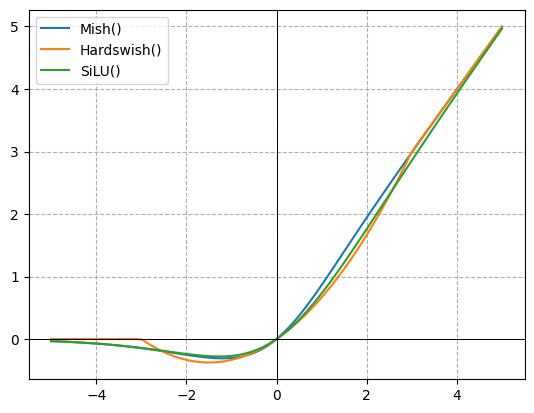

In [ ]:
def plot_func(*fs, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    for f in fs: plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)
    plt.legend([f for f in fs])
    
plot_func(Mish(), nn.Hardswish(), nn.SiLU())

## Mish

In [ ]:
class NormCB(Callback):
    def __init__(self, mean, std): fc.store_attr() 
    def before_batch(self, learn): TF.normalize(learn.batch[0], self.mean, self.std, inplace=True)
        

In [ ]:
fc.L([1,2])

(#2) [1,2]

batchsize 2048


accuracy,loss,epoch,train
0.774,0.812,0,train
0.410,2.102,0,eval
0.879,0.357,1,train
0.846,0.452,1,eval
0.908,0.258,2,train
0.902,0.281,2,eval
0.930,0.198,3,train
0.918,0.227,3,eval
0.946,0.156,4,train
0.926,0.207,4,eval


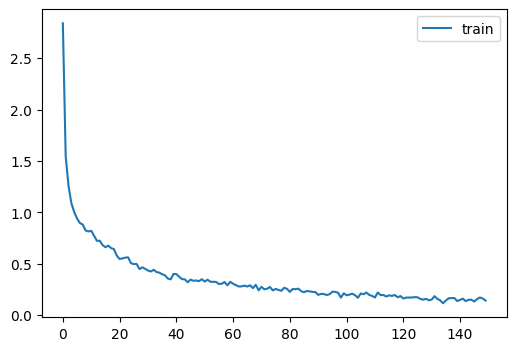

Fit 5 in: 22.41s, setup: 0.00s, 4.27 ± 0.10s per epoch, 0.02 ± 0.02s per batch


In [ ]:
def fit(act_gr=nn.Hardswish, m=8, epochs=5, bs=256, cbs=tuple(), iw=partial(init_weights, leaky=0.0003)):
    metrics = DevMetricsCB(accuracy=MulticlassAccuracy())
    #astats = ActivationStats(fc.risinstance(Mish))
    timeit = TimeItCB()
    bcbs = [DeviceCB(), metrics, LazyProgressCB(plot=True), timeit] + fc.L(cbs)
    
    set_seed(42)
    lr = 1e-2 *m
    dls = DataLoaders.from_dd(tds, bs*m, num_workers=0)
    print ('batchsize', dls.train.batch_size)
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    xtra = [BatchSchedCB(sched)]
    
    model = get_model7(act_gr, norm=nn.BatchNorm2d).apply(iw)
    learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=bcbs+xtra, opt_func=optim.AdamW)
    learn.fit(epochs)
fit(cbs=NormCB(0.28, 0.35))

batchsize 2048


accuracy,loss,epoch,train
0.774,0.805,0,train
0.746,0.972,0,eval
0.879,0.354,1,train
0.826,0.517,1,eval
0.903,0.269,2,train
0.903,0.272,2,eval
0.926,0.208,3,train
0.916,0.235,3,eval
0.943,0.162,4,train
0.923,0.214,4,eval


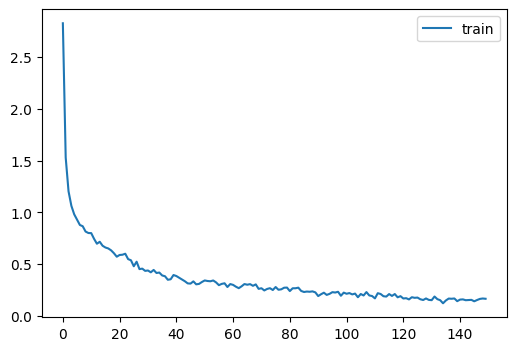

Fit 5 in: 22.59s, setup: 0.00s, 4.31 ± 0.11s per epoch, 0.02 ± 0.02s per batch


In [ ]:
fit(cbs=NormCB(0.5, 1.0))

batchsize 2048


accuracy,loss,epoch,train
0.765,0.824,0,train
0.695,1.083,0,eval
0.871,0.379,1,train
0.836,0.446,1,eval
0.902,0.273,2,train
0.893,0.301,2,eval
0.921,0.220,3,train
0.913,0.245,3,eval
0.939,0.173,4,train
0.920,0.227,4,eval


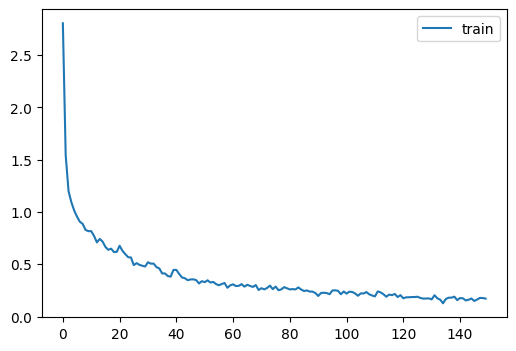

Fit 5 in: 22.86s, setup: 0.00s, 4.36 ± 0.17s per epoch, 0.02 ± 0.02s per batch


In [ ]:
fit(cbs=NormCB(0.0, 1.0))

batchsize 2048


accuracy,loss,epoch,train
0.773,0.814,0,train
0.565,1.427,0,eval
0.882,0.349,1,train
0.865,0.381,1,eval
0.909,0.256,2,train
0.897,0.290,2,eval
0.930,0.200,3,train
0.919,0.226,3,eval
0.947,0.154,4,train
0.927,0.206,4,eval


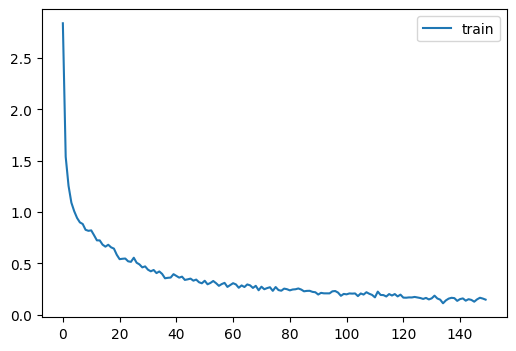

Fit 5 in: 22.57s, setup: 0.00s, 4.30 ± 0.15s per epoch, 0.02 ± 0.02s per batch


In [ ]:
fit(cbs=NormCB(0.29, 0.35))

batchsize 2048


accuracy,loss,epoch,train
0.768,0.824,0,train
0.670,1.019,0,eval
0.874,0.369,1,train
0.871,0.370,1,eval
0.902,0.271,2,train
0.894,0.292,2,eval
0.924,0.215,3,train
0.913,0.240,3,eval
0.939,0.171,4,train
0.919,0.227,4,eval


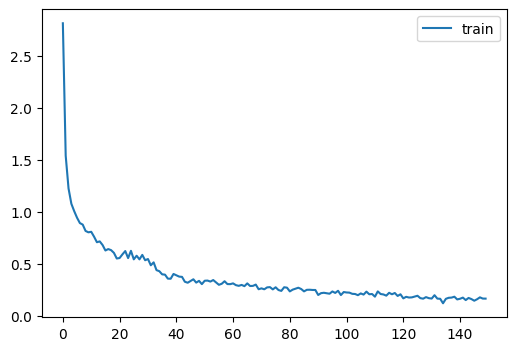

Fit 5 in: 22.66s, setup: 0.00s, 4.32 ± 0.11s per epoch, 0.02 ± 0.02s per batch


In [ ]:
fit(cbs=NormCB(0.29,1.0))

## SiLU / Swish

batchsize 2048


accuracy,loss,epoch,train
0.776,0.806,0,train
0.611,1.396,0,eval
0.724,0.817,1,train
0.510,1.503,1,eval
0.858,0.399,2,train
0.856,0.408,2,eval
0.892,0.303,3,train
0.879,0.336,3,eval
0.906,0.263,4,train
0.896,0.288,4,eval


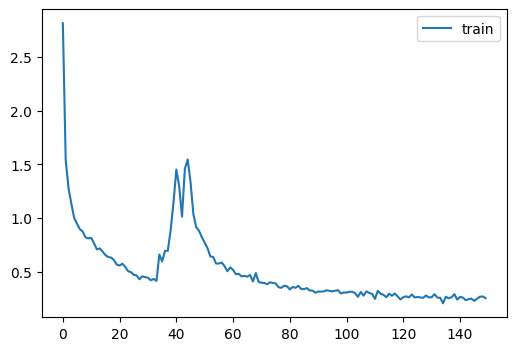

Fit 5 in: 22.62s, setup: 0.00s, 4.31 ± 0.15s per epoch, 0.02 ± 0.02s per batch


In [ ]:
fit(nn.SiLU, cbs=NormCB(0.29, 0.35))

batchsize 2048


accuracy,loss,epoch,train
0.775,0.805,0,train
0.611,1.388,0,eval
0.714,0.858,1,train
0.682,1.081,1,eval
0.855,0.403,2,train
0.871,0.366,2,eval
0.889,0.307,3,train
0.890,0.310,3,eval
0.905,0.266,4,train
0.893,0.289,4,eval


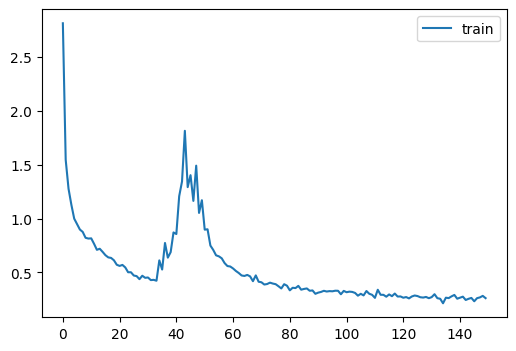

Fit 5 in: 22.61s, setup: 0.00s, 4.31 ± 0.16s per epoch, 0.02 ± 0.02s per batch


In [ ]:
fit(nn.SiLU, cbs=NormCB(0.28, 0.35))

## GeneralRelu

batchsize 2048


accuracy,loss,epoch,train
0.785,0.782,0,train
0.682,2.176,0,eval
0.875,0.371,1,train
0.774,0.658,1,eval
0.904,0.270,2,train
0.898,0.288,2,eval
0.926,0.210,3,train
0.920,0.230,3,eval
0.942,0.166,4,train
0.925,0.211,4,eval


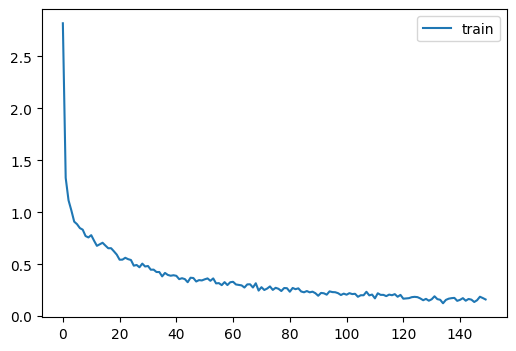

Fit 5 in: 23.15s, setup: 0.00s, 4.41 ± 0.14s per epoch, 0.02 ± 0.02s per batch


In [ ]:
fit(partial(GeneralRelu, leak=0.1, sub=0.4), cbs=NormCB(0.29, 0.35),iw=partial(init_weights, leaky=0.1))